In [1]:
import torch
import numpy as np
import open3d as o3d
import sys
sys.path.append('../src/')
import os

# only needed for tutorial, monkey patches visualization
sys.path.append('/home/ruslan/subt/thirdparty/Open3D/examples/python/')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists

### Load data

In [2]:
from depth_correction.depth_cloud import DepthCloud
sys.path.append('/home/ruslan/datasets/data/python/data/')
from asl_laser import Dataset

sequences_names = [
    'apartment',
    'eth',
    'gazebo_winter',
    'gazebo_summer',
    'plain',
    'stairs',
    'wood_summer',
    'wood_autumn'
]

data_path = '/home/ruslan/datasets/data/asl_laser/'

data = Dataset(path=os.path.join(data_path, sequences_names[0]))

points = torch.as_tensor(data.local_cloud(id=0)[::20, :])
dc = DepthCloud.from_points(pts=points)
torch.allclose(points, dc.to_points())

True

### Visualize point cloud

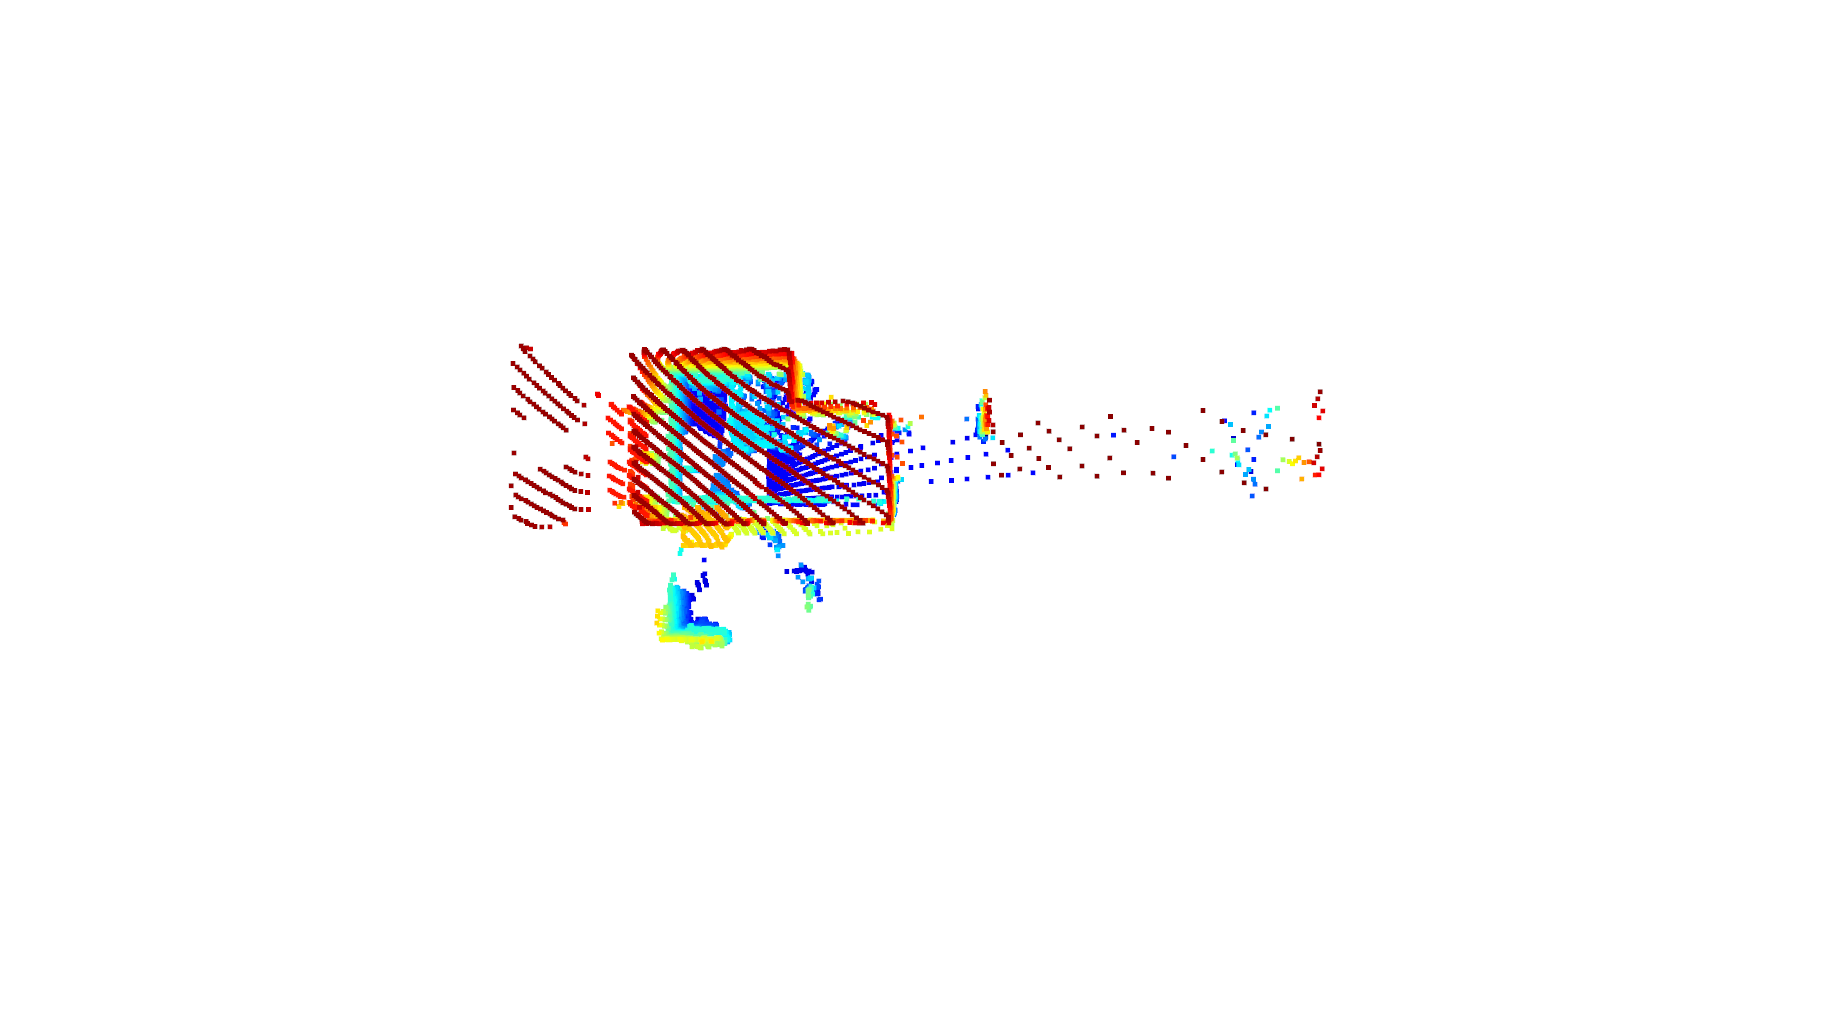

In [3]:
dc.visualize()

### Estimate normals

In [4]:
dc.estimate_normals()
# dc.estimate_incidence_angles()

# dc.visualize(normals=True)

### Convert to mesh

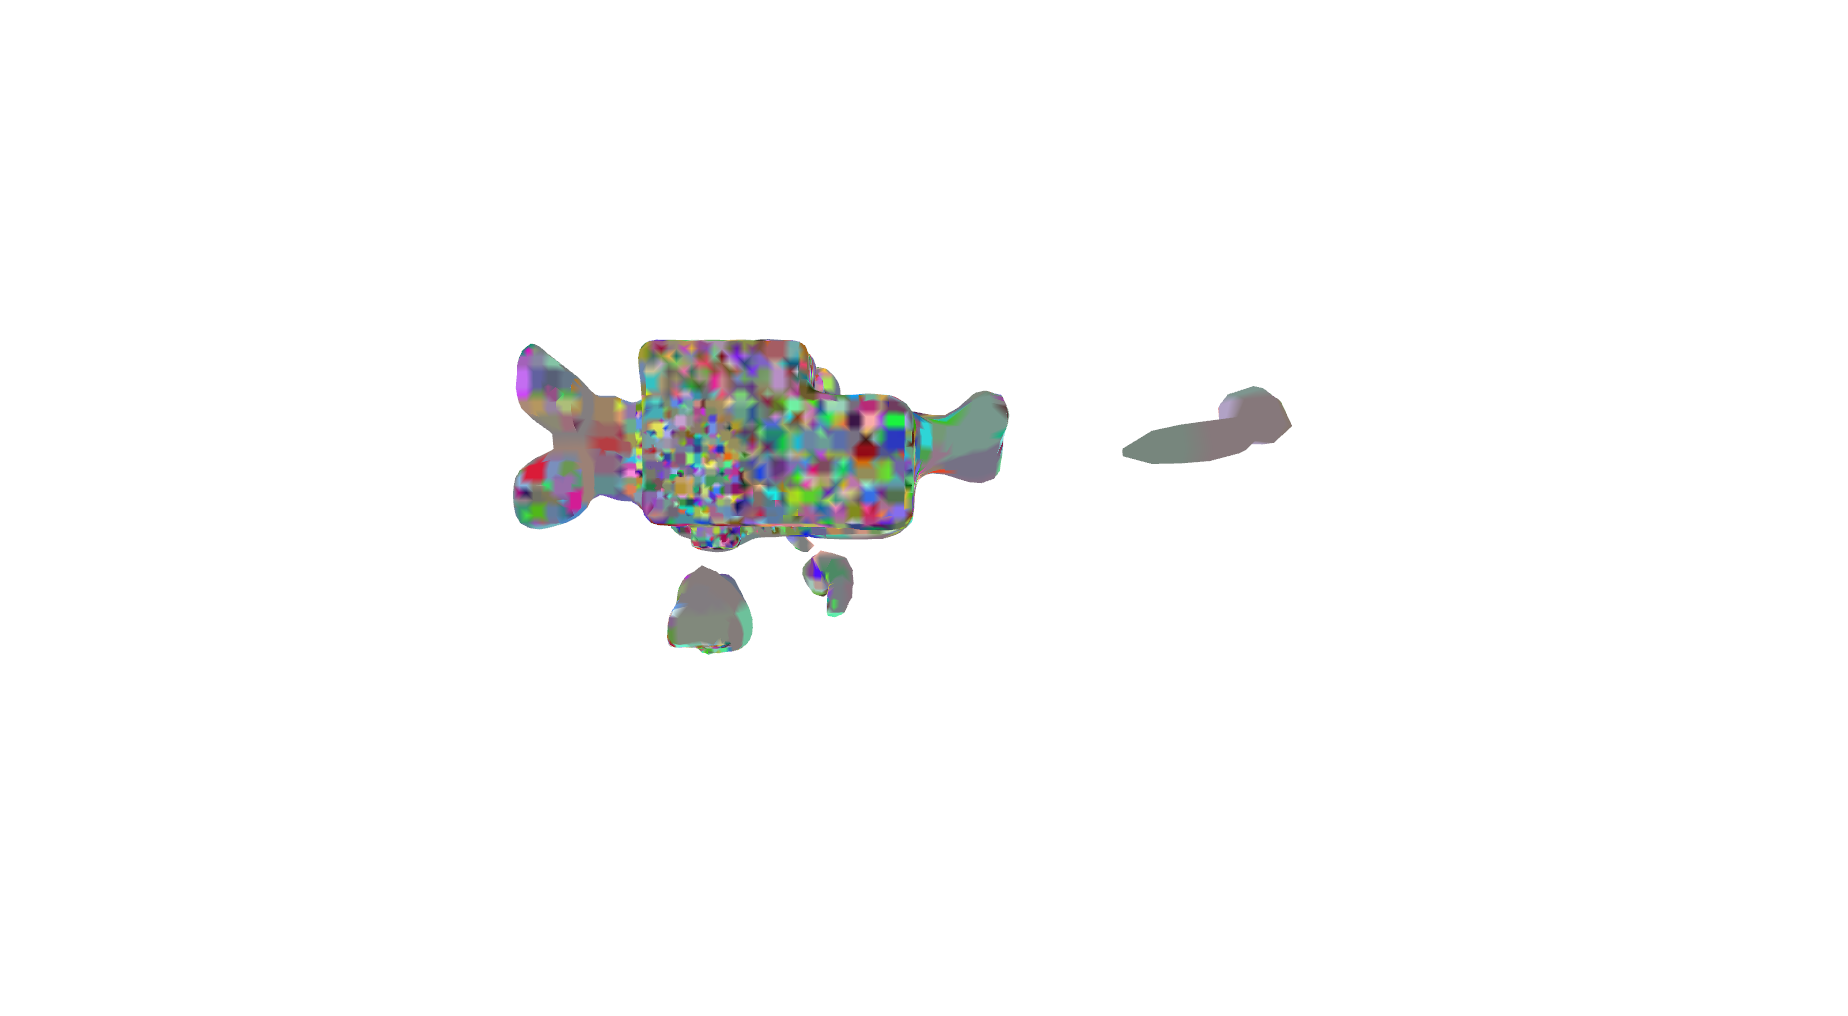

In [5]:
mesh_o3d = dc.to_mesh()

o3d.visualization.draw_geometries([mesh_o3d])

In [6]:
mesh = dc.to_pytorch3d_mesh()

In [7]:
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

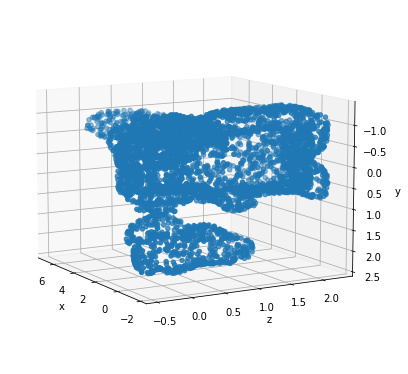

In [8]:
plot_pointcloud(mesh)

### Mesh consistency metrics

In [9]:
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

In [10]:
with torch.no_grad():
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(mesh, method="uniform")
    
    print('Edge length regularization:', loss_edge)
    print('Normals consistency:', loss_normal)
    print('Laplacian smoothing', loss_laplacian)

Edge length regularization: tensor(0.0046)
Normals consistency: tensor(0.0732)
Laplacian smoothing tensor(0.0176)
